In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


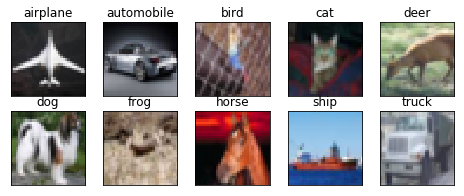

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
from keras.models import Model
from keras.layers import Activation, Conv2D, Input,SeparableConv2D,concatenate

# This returns a tensor
inputs = Input(shape=(32,32,3))
print(inputs)

W0627 04:02:07.843351 140686463375232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 04:02:07.881431 140686463375232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Tensor("input_1:0", shape=(?, 32, 32, 3), dtype=float32)


In [0]:
import tensorflow as tf
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2) 

In [9]:
## Network begins here ##


#----- 2. Depthwise Separable Convolution ------

x2 = SeparableConv2D(32,5, strides=(1, 1) , padding='same', name = 'Sep_x2')(inputs) # Output: 11x11
x2 = BatchNormalization(name = 'x2_bn')(x2)
x2 = Activation('relu')(x2)
skip_conn_x2=x2

#----- 2. Depthwise Separable Convolution ends here ------


#---- 3. Normal 5x5  convolution-----                     
x3 = Conv2D(32,5,  padding='same', name = 'x3')(x2)# Output: 26x26x128
x3 = BatchNormalization(name = 'x3_bn')(x3)
x3 = Activation('relu')(x3)

skip_conn_x3=x3
#---- 3. Normal 5x5 convolution ends here -----                  
 

#---- 4. Normal 5x5  convolution-----                     
x4 = Conv2D(32,5,  padding='same', name = 'x4')(x3)# Output: 26x26x128
x4 = BatchNormalization(name = 'x4_bn')(x4)
x4 = Activation('relu')(x4)

skip_conn_x4=x4                     
#---- 4. Normal 5x5 convolution ends here -----   


#---- Concatenation begins---

x4_concat=concatenate([x4,skip_conn_x2])

#---- Concatenation ends ---


#----- 5. Depthwise Separable Convolution ------

x5 = SeparableConv2D(512,5, strides=(1, 1) , padding='same', name = 'Sep_x5')(x4_concat) # Output: 11x11
x5 = BatchNormalization(name = 'x5_bn')(x5)
x5 = Activation('relu')(x5)

skip_conn_x5=x5

#----- 5. Depthwise Separable Convolution ends here ------


#---- Concatenation begins---

x5_concat=concatenate([x5,skip_conn_x2])

#---- Concatenation ends ---


#----- 6. Max Pooling begins ------

x6 = MaxPooling2D(pool_size=(2,2), name = 'MP_x6')(x5_concat) # Output: 13x13x128

#----- 6. Max Pooling ends ------


#------------------------

x6_1 = Conv2D(128,1,  padding='same', name = 'x6_1')(x6)# Output: 26x26x128
x6_1 = BatchNormalization(name = 'x6_1_bn')(x6_1)
x6_1 = Activation('relu')(x6_1)

#------------------------

#----- 7. Depthwise Separable Convolution ------

x7 = SeparableConv2D(32,3, strides=(1, 1) , padding='same', name = 'Sep_x7')(x6_1) # Output: 11x11
x7 = BatchNormalization(name = 'x7_bn')(x7)
x7 = Activation('relu')(x7)

skip_conn_x7=x7

#----- 7. Depthwise Separable Convolution ends here ------

#---- Concatenation begins---

s_d_2=Lambda(space_to_depth_x2)(skip_conn_x2)
s_d_5=Lambda(space_to_depth_x2)(skip_conn_x5)


x7_concat=concatenate([x7,s_d_2,s_d_5])

#---- Concatenation ends ---


#---- 8. Normal 5x5  convolution-----                     
x8 = Conv2D(64,5,  padding='same', name = 'x8')(x7_concat)# Output: 26x26x128
x8 = BatchNormalization(name = 'x8_bn')(x8)
x8 = Activation('relu')(x8)


skip_conn_x8=x8
#---- 8. Normal 5x5 convolution ends here ----


#---- Concatenation begins---

s_d_4=Lambda(space_to_depth_x2)(skip_conn_x4)



x8_concat=concatenate([x8,s_d_4,s_d_5,x7])

#---- Concatenation ends ---


#----- 9. Depthwise Separable Convolution ------

x9 = SeparableConv2D(128,3, strides=(1, 1), padding='same', name = 'Sep_x9')(x8_concat) # Output: 11x11
x9 = BatchNormalization(name = 'x9_bn')(x9)
x9 = Activation('relu')(x9)

skip_conn_x9=x9

#----- 9. Depthwise Separable Convolution ends here ------


#---- Concatenation begins---


x9_concat=concatenate([x9,s_d_2,s_d_4,x7])

#---- Concatenation ends ---



#----- 10. Depthwise Separable Convolution ------

x10 = SeparableConv2D(512,5, strides=(1, 1) ,  padding='same', name = 'Sep_x10')(x9_concat) # Output: 11x11
x10 = BatchNormalization(name = 'x10_bn')(x10)
x10 = Activation('relu')(x10)

skip_conn_x10=x10

#----- 10. Depthwise Separable Convolution ends here ------


#---- Concatenation begins---


x10_concat=concatenate([s_d_2,s_d_5,x7,x9,x10])

#---- Concatenation ends ---


#----- 11. Max Pooling begins ------

x11 = MaxPooling2D(pool_size= (2,2), name = 'MP_x11')(x10_concat) # Output: 13x13x128

#----- 11. Max Pooling ends ------


#------------------------

x11_1 = Conv2D(128,1,  padding='same', name = 'x11_1')(x11)# Output: 26x26x128
x11_1 = BatchNormalization(name = 'x11_1_bn')(x11_1)
x11_1 = Activation('relu')(x11_1)

#------------------------

#---- 12. Normal 5x5  convolution-----                     
x12 = Conv2D(32,5,  padding='same', name = 'x12')(x11_1)# Output: 26x26x128
x12 = BatchNormalization(name = 'x12_bn')(x12)
x12 = Activation('relu')(x12)

skip_conn_x12=x12
#---- 12. Normal 5x5 convolution ends here ----


#---- Concatenation begins---

s_d_3=Lambda(space_to_depth_x2)(skip_conn_x3)
s_d2_3=Lambda(space_to_depth_x2)(s_d_3)

s_d_5=Lambda(space_to_depth_x2)(skip_conn_x5)
s_d2_5=Lambda(space_to_depth_x2)(s_d_5)

s_d_9=Lambda(space_to_depth_x2)(skip_conn_x9)


x12_concat=concatenate([x12,s_d2_3,s_d2_5,s_d_9])

#---- Concatenation ends ---



#----- 13. Depthwise Separable Convolution ------

x13 = SeparableConv2D(64,5, strides=(1, 1) ,  padding='same', name = 'Sep_x13')(x12_concat) # Output: 11x11
x13 = BatchNormalization(name = 'x13_bn')(x13)
x13 = Activation('relu')(x13)

skip_conn_x13=x13

#----- 13. Depthwise Separable Convolution ends here ------


#---- Concatenation begins---

s_d_3=Lambda(space_to_depth_x2)(skip_conn_x3)
s_d2_3=Lambda(space_to_depth_x2)(s_d_3)

s_d_4=Lambda(space_to_depth_x2)(skip_conn_x4)
s_d2_4=Lambda(space_to_depth_x2)(s_d_4)

s_d_7=Lambda(space_to_depth_x2)(skip_conn_x7)

s_d_9=Lambda(space_to_depth_x2)(skip_conn_x9)


x13_concat=concatenate([x12,s_d2_3,s_d2_4,s_d_7,s_d_9,x13])

#---- Concatenation ends ---



#---- 14. Normal 3x3  convolution-----                     
x14 = Conv2D(128,3,  padding='same', name = 'x14')(x13_concat)# Output: 26x26x128
x14 = BatchNormalization(name = 'x14_bn')(x14)
x14 = Activation('relu')(x14)

skip_conn_x14=x14
#---- 14. Normal 3x3 convolution ends here ----


#---- Concatenation begins---

s_d_2=Lambda(space_to_depth_x2)(skip_conn_x2)
s_d2_2=Lambda(space_to_depth_x2)(s_d_2)

s_d_5=Lambda(space_to_depth_x2)(skip_conn_x5)
s_d2_5=Lambda(space_to_depth_x2)(s_d_5)


x14_concat=concatenate([s_d2_2,s_d2_4,s_d2_5,s_d_7,s_d_9,x13,x14])

#---- Concatenation ends ---


#----- 15. Depthwise Separable Convolution ------

x15 = SeparableConv2D(512,5, strides=(1, 1) , padding='same', name = 'Sep_x15')(x14_concat) # Output: 11x11
x15 = BatchNormalization(name = 'x15_bn')(x15)
x15 = Activation('relu')(x15)

skip_conn_x15=x15

#----- 15. Depthwise Separable Convolution ends here ------


#---- Concatenation begins---

s_d_5=Lambda(space_to_depth_x2)(skip_conn_x5)
s_d2_5=Lambda(space_to_depth_x2)(s_d_5)


x15_concat=concatenate([s_d2_5,s_d_9,x13,x15])

#---- Concatenation ends ---


#------------------------

x15_1 = Conv2D(128,1,  padding='same', name = 'x15_1')(x15_concat)# Output: 26x26x128
x11_1 = BatchNormalization(name = 'x15_1_bn')(x15_1)
x11_1 = Activation('relu')(x15_1)

#------------------------


x16 = Conv2D(10,8, name = 'x16')(x15_1)# Output: 26x26x128

flayer = Flatten()(x16)

output = Activation('softmax')(flayer)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0627 04:02:08.332174 140686463375232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 04:02:08.384479 140686463375232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0627 04:02:08.385434 140686463375232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0627 04:02:11.475002 140686463375232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0627 04:02:11.888018 1406

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Sep_x2 (SeparableConv2D)        (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
x2_bn (BatchNormalization)      (None, 32, 32, 32)   128         Sep_x2[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           x2_bn[0][0]                      
__________________________________________________________________________________________________
x3 (Conv2D

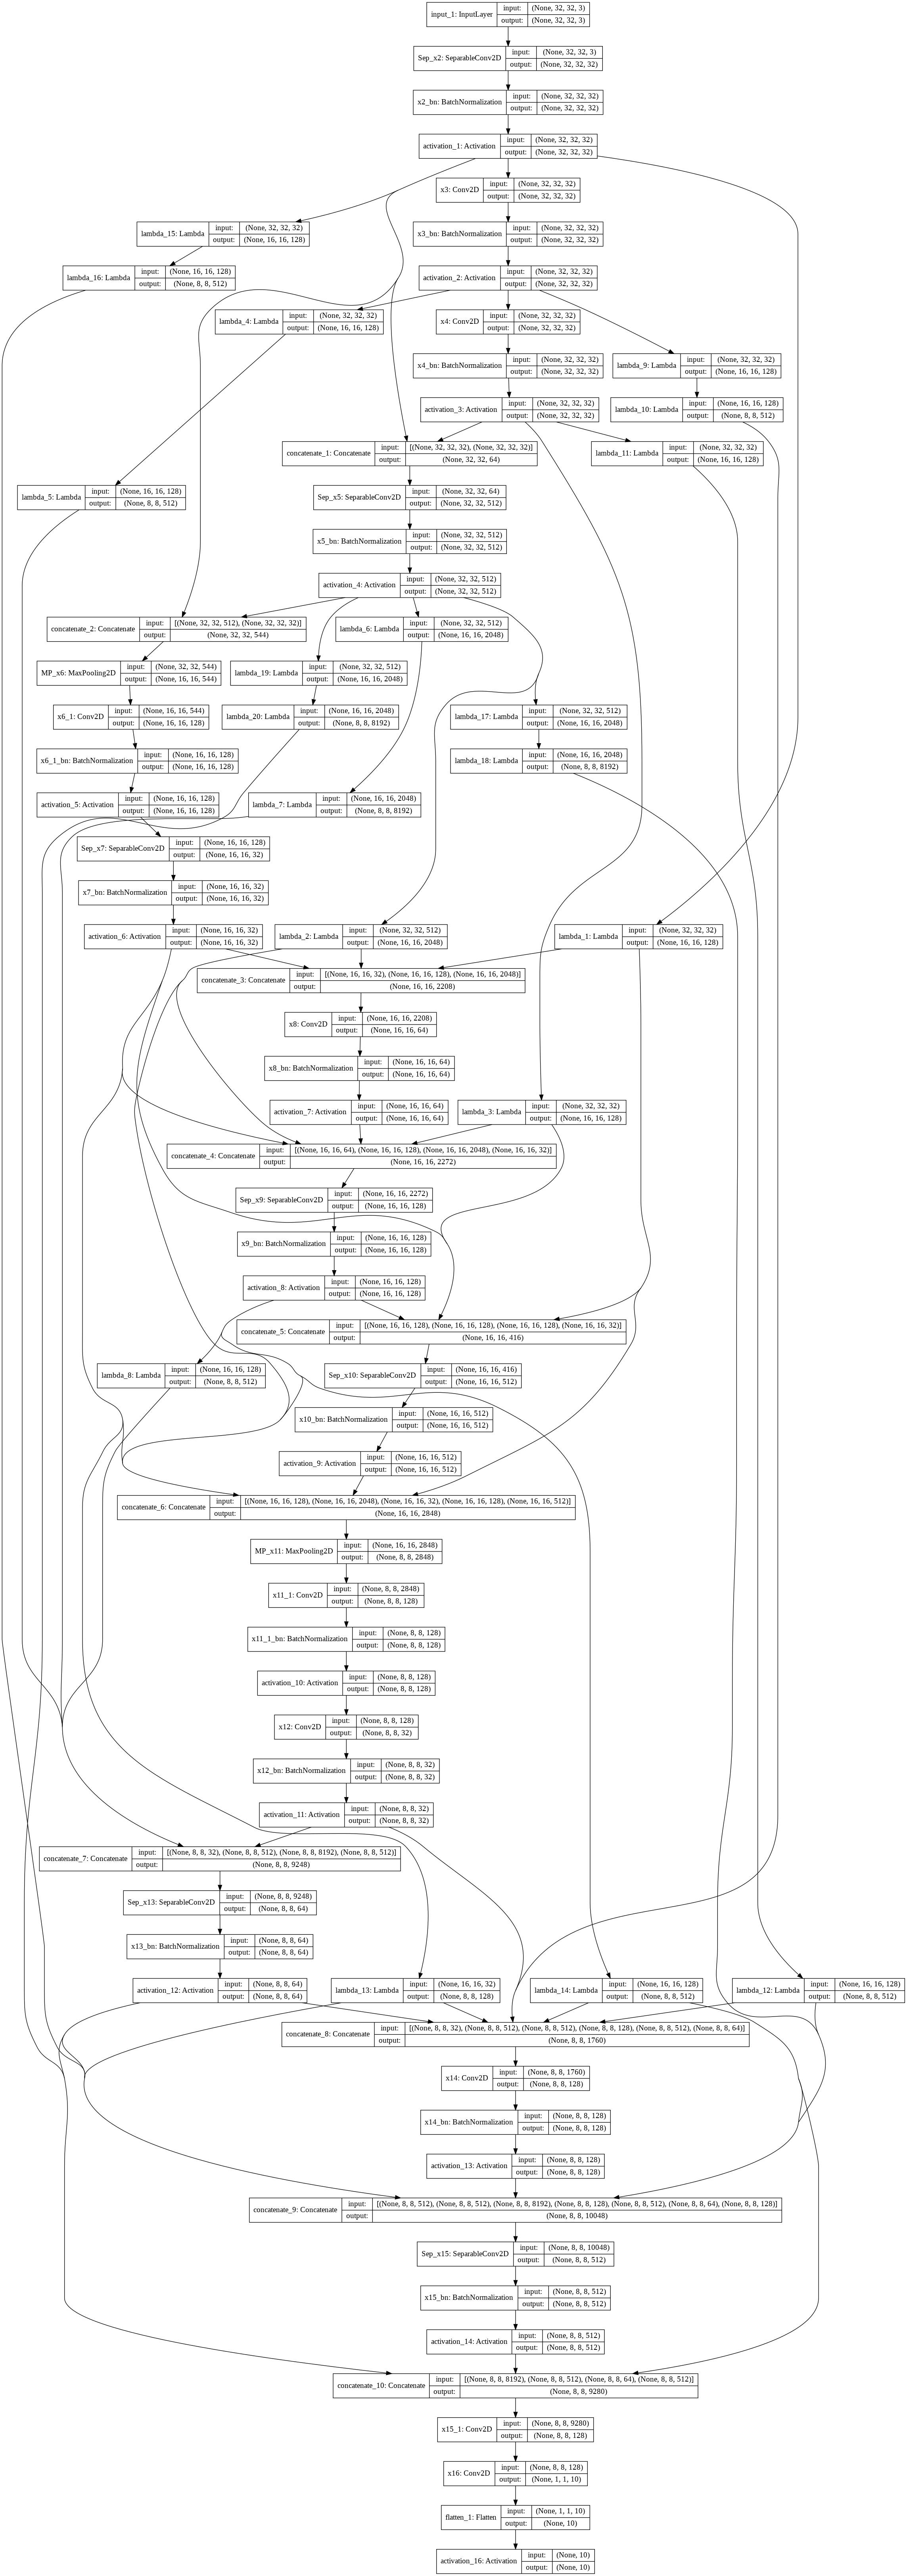

In [11]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='enas_model_structure_A7B.png')

from IPython.display import Image
Image(retina=True, filename='enas_model_structure_A7B.png')

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch =100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0627 04:02:14.671764 140686463375232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
390/390 [==============================] - 218s 558ms/step - loss: 13.5817 - acc: 0.1521 - val_loss: 13.5559 - val_acc: 0.1588
Epoch 2/100
390/390 [==============================] - 204s 524ms/step - loss: 13.5900 - acc: 0.1566 - val_loss: 13.4493 - val_acc: 0.1654
Epoch 3/100
390/390 [==============================] - 200s 512ms/step - loss: 13.4329 - acc: 0.1665 - val_loss: 13.0567 - val_acc: 0.1899
Epoch 4/100
390/390 [==============================] - 199s 509ms/step - loss: 13.4082 - acc: 0.1681 - val_loss: 13.3794 - val_acc: 0.1699
Epoch 5/100
390/390 [==============================] - 199s 510ms/step - loss: 13.1935 - acc: 0.1814 - val_loss: 13.7310 - val_acc: 0.1481
Epoch 6/100
390/390 [==============================] - 199s 509ms/step - loss: 13.0450 - acc: 0.1906 - val_loss: 13.0363 - val_acc: 0.1912
Epoch 7/100
390/390 [==============================] - 199s 510ms/step - loss: 13.1185 - acc: 0.1861 - val_loss: 13.1037 - val_acc: 0.1868
Epoch 8/100
390/390 [======

KeyboardInterrupt: ignored